In [7]:
import cv2
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import SGDClassifier
import seaborn as sns

In [2]:
def read_file(file_name):
# Opening JSON file
    try:
        with open(file_name, "r") as f:
            x = [line.strip() for line in f.readlines()]
#             print(x)
            header = x[0].split(',')
            data_set = {
                "id": [],
                "label": []
            }
            if len(header) == 2 and header[0] == "id" and header[1] == "label":
                for line in range(1, len(x)):
                    data = x[line].split(",")
                    data_set["id"].append(data[0])
                    data_set["label"].append(data[1])
            elif header[0] == "id" and len(header) < 2:
                data_set["id"] = x[1:]
            else:
                raise Exception("File doesn't have the required format")
            
            return data_set
    except Exception as e:
        return e

In [3]:
def read_images(folder_path, filenames):
    start = time.time()
    arrays = []
    for filename in filenames:
        arrays.append(plt.imread(os.path.join(folder_path,filename)))
    print("Time for reading images in {}:".format(folder_path), time.time() - start)
    return np.array(arrays)

In [4]:
test_data = read_file("test.txt")
train_data = read_file("train.txt")
validation_data = read_file("validation.txt")

train_images = read_images("train+validation", train_data["id"])
test_images= read_images("test", test_data["id"])
validation_images = read_images("train+validation", validation_data["id"])

Time for reading images in train+validation: 317.27966833114624
Time for reading images in test: 49.65320920944214
Time for reading images in train+validation: 16.064701080322266


In [5]:
def normalize_images(images, axis=(1,2)): 
    mean = np.mean(images, axis=axis, keepdims=True)
    standard = np.sqrt(((images - mean)**2).mean(axis=axis, keepdims=True))
    new_array = (images - mean) / standard
    return new_array

def normalize_images_old(images):
#     return cv2.normalize(img,  np.zeros((16,16)), 0, 255, cv2.NORM_MINMAX)
    return np.array([cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten() for img in images])


def normalize_images_new(images):
#     return cv2.normalize(img,  np.zeros((16,16)), 0, 255, cv2.NORM_MINMAX)
    return images / 255

    
def normalize_flatten_images(images):
    return normalize_images_old(images)


train_images_normalized = normalize_flatten_images(train_images)
validation_images_normalized = normalize_flatten_images(validation_images)
test_images_normalized = normalize_flatten_images(test_images)

print("done")

done


In [19]:
def classifier(X_train, y_train, model_number = 0):
    start = time.time()
    match model_number:
        case 1:
            clf = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf'))  # 0.55
        case 2:
            clf = make_pipeline(Normalizer(), svm.SVC(kernel='rbf'))  # 0.53
        case 3:
            clf = make_pipeline(StandardScaler(), SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))  # 0,44
        case 4:
            clf = make_pipeline(StandardScaler(with_mean=False), svm.LinearSVC(random_state=0, tol=1e-5, max_iter = 10000))  # 0.47
        case _:        
            clf = svm.SVC(kernel='rbf')  # 0.54

    clf.fit(X_train, y_train)
    print("Classification time: {}".format(time.time() - start))
    return clf


def metrics_data(classes, predicted_classes):
    return metrics.classification_report(classes, predicted_classes), metrics.confusion_matrix(classes, predicted_classes)

X_train = train_images_normalized
X_validate = validation_images_normalized
X_test = test_images_normalized
y_train = train_data["label"]
y_validate = validation_data["label"]

clf_train = []

for model in range(5):
    clf_train.append(classifier(X_train, y_train, model))

Classification time: 46.25353693962097
Classification time: 43.75365138053894
Classification time: 49.1699275970459
Classification time: 10.862793445587158
Classification time: 623.5453910827637


C:\Users\LENOVO\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
clf_train = clf_train[:5]

In [36]:
predicted_validate = []
cm = []
cr = []
for model in range(5):
    predicted_validate.append(clf_train[model].predict(X_validate))
    local_cr, local_cm = metrics_data(y_validate, predicted_validate[model])
    cr.append(local_cr)
    cm.append(local_cm)
    print(cr[model])
    

              precision    recall  f1-score   support

           0       0.76      0.59      0.66       216
           1       0.42      0.36      0.39       201
           2       0.63      0.80      0.71       142
           3       0.45      0.59      0.51       150
           4       0.63      0.71      0.67       143
           5       0.37      0.37      0.37       145
           6       0.48      0.42      0.45       176

    accuracy                           0.54      1173
   macro avg       0.54      0.55      0.54      1173
weighted avg       0.54      0.54      0.53      1173

              precision    recall  f1-score   support

           0       0.78      0.60      0.68       216
           1       0.42      0.36      0.39       201
           2       0.63      0.80      0.70       142
           3       0.47      0.60      0.53       150
           4       0.64      0.71      0.67       143
           5       0.39      0.39      0.39       145
           6       0.50 

<AxesSubplot:>

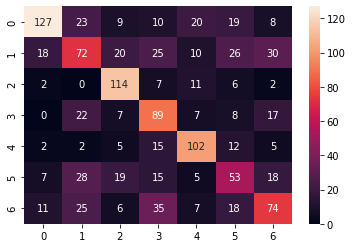

In [37]:
sns.heatmap(cm[0], annot=True, fmt='')

<AxesSubplot:>

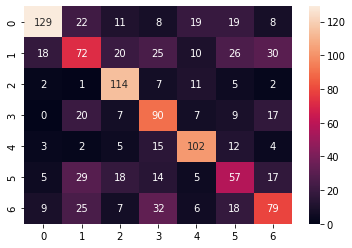

In [38]:
sns.heatmap(cm[1], annot=True, fmt='')

<AxesSubplot:>

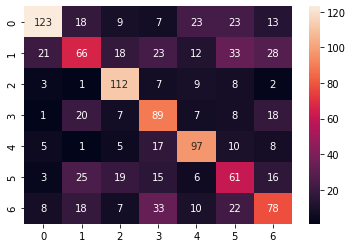

In [39]:
sns.heatmap(cm[2], annot=True, fmt='')

<AxesSubplot:>

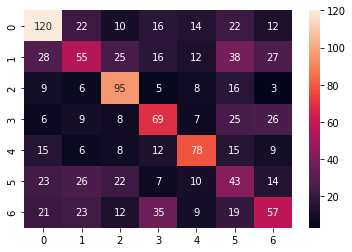

In [40]:
sns.heatmap(cm[3], annot=True, fmt='')

<AxesSubplot:>

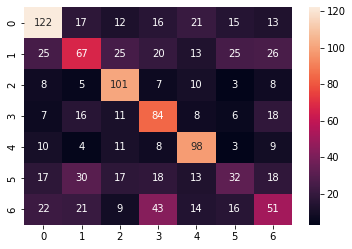

In [41]:
sns.heatmap(cm[4], annot=True, fmt='')

In [ ]:
# cr_0 = metrics_data(y_validate, predicted_validate)

In [ ]:
test_data["label"] = list(predicted_test)
print(test_data["label"][:20])
print(len(test_data["label"]))

In [ ]:
test_data["label"] = list(predicted_test)
print(test_data["label"][:20])
print(len(test_data["label"]))

In [ ]:
with open('test_submission.txt', 'w') as f:
    f.write('id,label\n')
    f.write('\n'.join(["{},{}".format(id_image,label) for id_image, label in zip(test_data["id"],test_data["label"])]))

In [ ]:
print(len(train_images))